# Classification. Linear models and KNN

In [149]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [151]:
PATH = "./data/"

In [152]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [153]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

*Количество женщин и мужчин в датасете*

In [154]:
women = data.loc[data.Sex == 'female']['Survived'].count()
men = data.loc[data.Sex == 'male']['Survived'].count()
print('{} Females in dataset \n{} Males in dataset'.format(women, men))

314 Females in dataset 
577 Males in dataset


*Выжившшие пассажиры сгруппированные по полу*

In [155]:
survived = data.groupby(by='Sex')['Survived'].sum()
print('Survived {} females in dataset \nSurvived {} males in dataset'.format(survived[0], survived[1]))

Survived 233 females in dataset 
Survived 109 males in dataset


*Процент выживших по каждому полу*

In [156]:
rate_women = survived[0]/women
rate_men = survived[1]/men
print('{:.2f} % of women who survived \n{:.2f} % of men who survived'.format(rate_women*100, rate_men*100))

74.20 % of women who survived 
18.89 % of men who survived


< your thoughts >

*Как видно из процентного соотношения, большая часть женского пола выжила, в отличие от мужчин. Скорее всего это связано, с тем, что мужья спасали своих жен и детей, давая им место в спасательных лодках.* 

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [381]:
plot_date = data.groupby(by='Age')['Survived'].count()
plot_date_surv = data.loc[data.Survived == 1].groupby(by='Age')['Survived'].count()
plot_date_dec = data.loc[data.Survived == 0].groupby(by='Age')['Survived'].count()

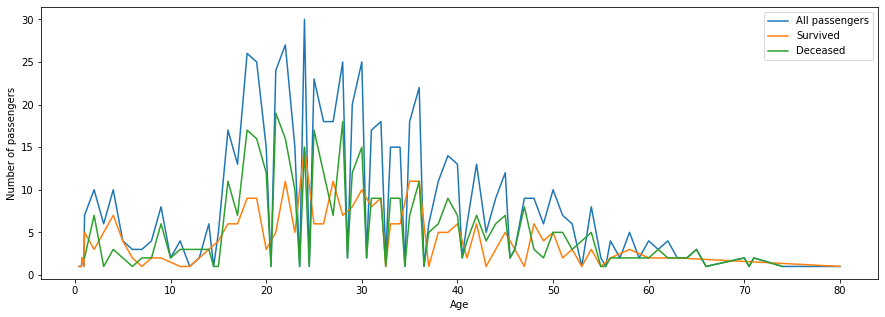

In [382]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=plot_date.index, y=plot_date)
ax = sns.lineplot(x=plot_date_surv.index, y=plot_date_surv)
ax = sns.lineplot(x=plot_date_dec.index, y=plot_date_dec)
plt.legend(labels=['All passengers', 'Survived', 'Deceased'])
ax.set(ylabel='Number of passengers')
plt.show()

*Как видно из графиков, основная часть пассажиров была в возрасте от 20 до 40 лет. Соответственно и количество погибших в этом диапазоне также велико.*

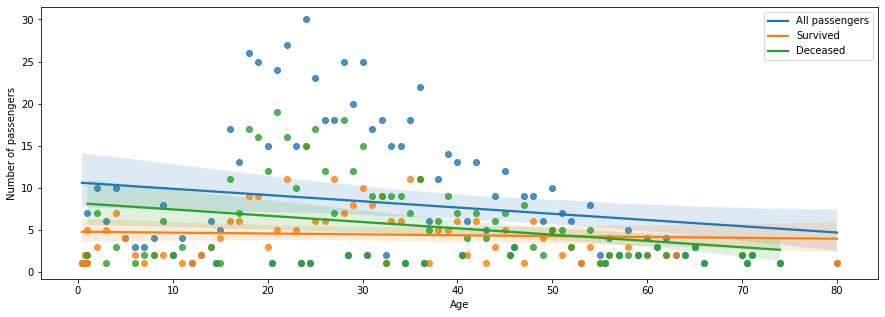

In [385]:
plt.figure(figsize=(15, 5))
ax = sns.regplot(x=plot_date.index, y=plot_date)
ax = sns.regplot(x=plot_date_surv.index, y=plot_date_surv)
ax = sns.regplot(x=plot_date_dec.index, y=plot_date_dec)
plt.legend(labels=['All passengers', 'Survived', 'Deceased'])
ax.set(ylabel='Number of passengers')
plt.show()

In [386]:
## your code
all_mean = data.Age.mean()
all_median = data.Age.median()
all_max = data.Age.max()
all_min = data.Age.min()
print('{:.2f} - min age \n{:.2f} - max age'.format(all_min, all_max))
print('----------------------------------')
print('{:.2f} - mean age all passengers \n{:.2f} - median age all passengers'.format(all_mean, all_median))
print('----------------------------------')
surv_mean = data.loc[data.Survived == 1]['Age'].mean()
surv_median = data.loc[data.Survived == 1]['Age'].median()
print('{:.2f} - mean age who survived \n{:.2f} - median age who survived'.format(surv_mean, surv_median))
print('----------------------------------')
dec_mean = data.loc[data.Survived == 0]['Age'].mean()
dec_median = data.loc[data.Survived == 0]['Age'].median()
print('{:.2f} - mean age who deceased \n{:.2f} - median age who deceased'.format(dec_mean, dec_median))

0.42 - min age 
80.00 - max age
----------------------------------
29.70 - mean age all passengers 
28.00 - median age all passengers
----------------------------------
28.34 - mean age who survived 
28.00 - median age who survived
----------------------------------
30.63 - mean age who deceased 
28.00 - median age who deceased


*Средний возраст вышивжих и погибших почти одинаков: разница в 2 года невелика в сравнении с тем,
что минимальный возраст пассажриров был менее 1 года, а максимальный - 80.
Медиана равна 28 во всех случаях. Скорее всего это связано с тем, что как отмечалось выше, большая часть пассажиров была в возрасте от 20 до 40 лет.*

< your thoughts >

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [439]:
#сгруппируем по классу каюты вышивших и погибших пассажиров
class_surv = data.loc[data.Survived == 1].groupby(by='Pclass')['Survived'].count()
class_dec = data.loc[data.Survived == 0].groupby(by='Pclass')['Survived'].count()
emb_surv = data.loc[data.Survived == 1].groupby(by='Embarked')['Survived'].count()
emb_dec = data.loc[data.Survived == 0].groupby(by='Embarked')['Survived'].count()
#переименуем серию "emb_dec" для корректного отображения на графике и в таблице
emb_dec.name = 'Deceased'

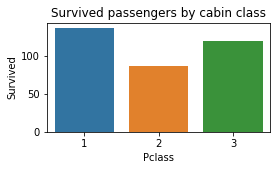

In [440]:
plt.figure(figsize=(4, 2))
plt.title('Survived passengers by cabin class')
sns.barplot(x=class_surv.index, y=class_surv)

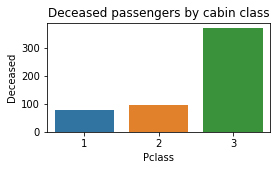

In [441]:
plt.figure(figsize=(4, 2))
plt.title('Deceased passengers by cabin class')
ax = sns.barplot(x=class_dec.index, y=class_dec)
ax.set(xlabel='Pclass', ylabel='Deceased')
plt.show()

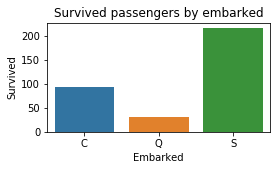

In [442]:
plt.figure(figsize=(4, 2))
plt.title('Survived passengers by embarked')
sns.barplot(x=emb_surv.index, y=emb_surv)

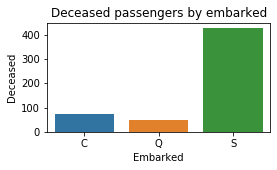

In [443]:
plt.figure(figsize=(4, 2))
plt.title('Deceased passengers by embarked')
ax = sns.barplot(x=emb_dec.index, y=emb_dec)

In [444]:
all_emb = pd.DataFrame(data=[emb_surv, emb_dec])
all_emb

Embarked,C,Q,S
Survived,93,30,217
Deceased,75,47,427


*Как видно из графиков, наиболее "безопасным" был наиболее дорогой 1-ый класс, в котором
число вышивших пассажиров превышает число во 2-ом или 3-ем классе. Это объясняется тем, что более
влиятельным пассажирам еще до начала паники были предложены места в спасатльных шлюпках. 
Также на графиках и в таблице видно, что основная часть как погибших, так и выживших садилась в порту "S" - Саутгемптоне. 
Это объясняется тем, что порт отправки корабля также был Саутгемптон, т.е. в этом порту на посадку зашла основная часть пассажиров. Остановка в Шербуре "C" (Франция) вероятно была для того, чтобы забрать пассажиров с "большого" континента, а остановка в Квинстауне "Q" помимо забора последних пассажиров предназначалась для пополнения запасов провизии.*

< your thoughts >

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [445]:
## your code
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

*Посмотрим на количество уникальных значений признака "Age" в данных*

In [470]:
print('{} уникальных значений в колонке "Age" из общих {}'.format(data.Age.nunique(),len(data.index)))

88 уникальных значений в колонке "Age" из общих 891


*Посмотрим на количество уникальных значений признака "Cabin" в данных*

In [473]:
print('{} уникальных значений в колонке "Cabin" из общих {}'.format(data.Cabin.nunique(),len(data.index)))

147 уникальных значений в колонке "Cabin" из общих 891


In [474]:
data.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [478]:
data[data['Cabin'] == 'B80']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C


*Можно сделать вывод, что отсутствующие значения можно отбросить* 

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [483]:
prep_data = data.dropna()

In [487]:
y = prep_data['Survived']
prep_data = prep_data.drop('Survived', axis=1)

In [490]:
cat_cols = [cname for cname in prep_data.columns if
                    prep_data[cname].dtype == "object"]
num_cols = [cname for cname in prep_data.columns if 
                prep_data[cname].dtype in ['int64', 'float64']]
my_cols = cat_cols + num_cols

In [493]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'],
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

In [11]:
## your code

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [12]:
## your code

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [13]:
## your code

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [15]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [16]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [17]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [20]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

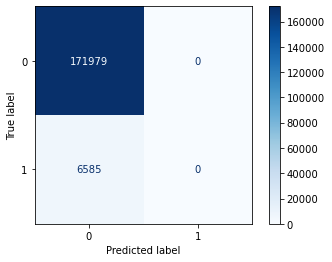

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

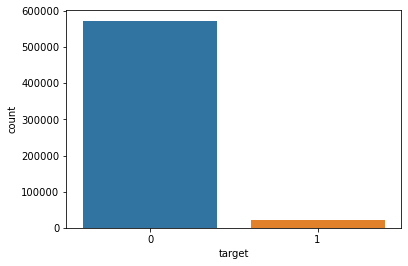

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [24]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [27]:
## your code